In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

SyntaxError: invalid syntax (<string>, line 1)

In [1]:
import comet_ml
experiment = comet_ml.Experiment(project_name="2019nn_beer")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/aeryen/2019nn-beer/5196a9f232624eb79d3870117a9f6ba7



In [2]:
# %%
from fastai.text import *
from data_helpers.Data import *
from fastai.text.transform import *

In [3]:
hyper_params = {
    "max_sequence_length": 20*70,
    "batch_size": 32,
    "num_epochs1": 12,
    "num_epochs2": 15,
    "num_aspect": 5,
    "num_rating": 5,
}

In [4]:
experiment.log_parameters(hyper_params)

In [5]:
torch.cuda.set_device('cuda:0')

# Load LM Databunch and LM Learner

In [7]:
# lm_db = load_data("./data/", "hotel_lm_databunch.1001")
# lm_learn = language_model_learner(lm_db, AWD_LSTM)
# lm_learn = lm_learn.load("lang_model_hotel")

In [8]:
# lm_learn.save_encoder('lang_model_hotel_enc')

In [7]:
cls_db = load_data("./data/", "beer_clas_databunch_rint.TraValTes")
cls_db.batch_size = hyper_params["batch_size"]
cls_db.batch_size

32

In [8]:
cls_db.show_batch()

text,target
xxbos xxmaj watching some football tonight ( xxup xxunk ) and having the last of my 2005 and 2006 xxmaj bigfoots ( xxmaj bigfeet ? ? ) xxperiod xxmaj lots of malt in there xxperiod toffee and caramel xxperiod very xxmaj english - like these days xxperiod quite tasty xxperiod xxmaj just one 2004 left xxperiod :-( xxmaj cheers ! ! xxperiod * * * * * * xxperiod xxmaj,
"xxbos i had tried this once before , but the bottle i had purchased was smothered in dust and might as well have been in a petrified state by the time i got to it xxperiod xxmaj despite its robust 8 xxperiod 3 % abv , it is still a bit too weak to age gracefully , and it was clear that the flavor had been compromised , calling for",
"xxbos i feel strange reviewing this brew first before reviewing any other xxmaj founders offerings , because they really do a great job and i feel like by not giving this an xxup a+ i 'm understating how fantastic this brewery is on the whole xxperiod xxmaj but i have to keep the style and other examples i 've had of the style in mind , so here 's my",
"xxbos i picked up a bottle of xxmaj bigfoot xxmaj barleywine xxmaj style xxmaj ale for $ 1 xxperiod 99 at xxmaj the xxmaj lager xxmaj mill xxperiod i have been wanting to try this beer for a while since i heard it was one the better xxmaj barleywines available , but every time i thought to pick one up they were sold out for the season , but i",
xxbos xxmaj re - review xxperiod xxmaj turns out the first bottles of this i had was from an infected batch xxperiod i had it before the infection really took off but it would explain the lactic quality i was picking up xxperiod 12 oz bottled 2nd week of xxmaj november 2010 xxperiod xxmaj served at cellar temperature xxperiod xxmaj pours dark brown / black with a large light brown,


In [16]:
x,y = cls_db.one_batch()

In [17]:
x.shape

torch.Size([32, 1347])

# Tools

### Sentence Feature Combo Pooling (1200)

In [9]:
def pool_combo(output, start, end):
    avg_pool = output[start:end, :].mean(dim=0)
    max_pool = output[start:end, :].max(dim=0)[0]
    x = torch.cat([output[-1, :], max_pool, avg_pool], 0)
    return x


def sentence_pool_1200(outputs, mask, p_index):
    output = outputs[-1]
    seq_max = output.size(1)
    doc_start = mask.int().sum(dim=1)

    batch = []
    for doci in range(0, output.shape[0]):
        pi = p_index[doci, :].nonzero(as_tuple=True)[0].int()
        doc = []
        for senti in range(len(pi)):
            if senti == 0:
                doc.append(pool_combo(output[doci, :, :], doc_start[doci], pi[senti]))
            else:
                doc.append(pool_combo(output[doci, :, :], pi[senti - 1] + 1, pi[senti]))

        batch.append(torch.stack(doc, 0))

    return batch


def sentence_pool_400(output:Tensor, mask, p_index):
    batch = []
    for doci in range(0, output.shape[0]):
        doc = output[doci, p_index[doci, :], :]
        batch.append(doc)

    return batch


def masked_concat_pool(outputs, mask):
    "Pool MultiBatchEncoder outputs into one vector [last_hidden, max_pool, avg_pool]."
    output = outputs[-1]
    avg_pool = output.masked_fill(mask[:, :, None], 0).mean(dim=1)
    avg_pool *= (
        output.size(1) / (output.size(1) - mask.type(avg_pool.dtype).sum(dim=1))[:, None]
    )
    max_pool = output.masked_fill(mask[:, :, None], -float("inf")).max(dim=1)[0]
    x = torch.cat([output[:, -1], max_pool, avg_pool], 1)
    return x

## DEFINE MODEL

In [10]:
class SentenceEncoder(Module):
    "Create an encoder over `module` that can process a full sentence."
    
    def __init__(self, bptt:int, max_len:int, module:nn.Module, vocab, pad_idx:int=1):
        print("Encoder initing")
        self.max_len,self.bptt,self.module,self.pad_idx = max_len,bptt,module,pad_idx
        print("max len " + str(self.max_len))
        print("bptt " + str(self.bptt))
        print("pad_idx " + str(self.pad_idx))
        self.vocab = vocab
        self.period_index = self.vocab.stoi["xxperiod"]
        print("period index " + str(self.period_index))

    def concat(self, arrs:Collection[Tensor])->Tensor:
        "Concatenate the `arrs` along the batch dimension."
        return [torch.cat([l[si] for l in arrs], dim=1) for si in range_of(arrs[0])]

    def reset(self):
        if hasattr(self.module, 'reset'): self.module.reset()

    def forward(self, input:LongTensor)->Tuple[Tensor,Tensor]:
        bs,sl = input.size()
        self.reset()
        
        bptt = self.bptt
        if np.random.random() > 0.95:
            bptt = 50
        
        raw_outputs,outputs,masks = [],[],[]
        p_index = []
        for i in range(0, sl, bptt):
            r, o = self.module(input[:,i: min(i+bptt, sl)])
            if i>(sl-self.max_len):
                masks.append(input[:,i: min(i+bptt, sl)] == self.pad_idx)
                raw_outputs.append(r)
                outputs.append(o)
                p_index.append( input[:,i: min(i+bptt, sl)] == self.period_index )

#         print("number of sentences in docs:")
#         n_sent = torch.sum( x==self.vocab.stoi["xxperiod"] , dim=1)
#         print(n_sent)
        
        period_index = torch.cat(p_index,dim=1)
        
        return self.concat(raw_outputs),self.concat(outputs), \
               torch.cat(masks,dim=1),period_index

In [10]:
class BI_AWD_LSTM(AWD_LSTM):
    def __init__(self, vocab_sz:int, emb_sz:int, n_hid:int, pad_token:int=1, hidden_p:float=0.2,
                 input_p:float=0.6, embed_p:float=0.1, weight_p:float=0.5, bidir:bool=False):
        self.bs,self.emb_sz,self.n_hid = 1,emb_sz,n_hid
        self.n_dir = 2 if bidir else 1
        self.encoder = nn.Embedding(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder_dp = EmbeddingDropout(self.encoder, embed_p)
 
        self.rnns = [
            nn.LSTM(emb_sz, n_hid//self.n_dir, 1,
                 batch_first=True, bidirectional=bidir),
            nn.LSTM(n_hid, n_hid//self.n_dir, 1,
                 batch_first=True, bidirectional=bidir)
        ]
        
        self.rnns.extend( [ nn.LSTM(n_hid, emb_sz//self.n_dir, 1,
                                    batch_first=True, bidirectional=bidir) ] * 2 )
        
        for i in range(len(self.rnns)):
            self.rnns[i] = WeightDropout(self.rnns[i], weight_p)
        
        self.rnns = nn.ModuleList(self.rnns)
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        if self.encoder.padding_idx is not None:
            self.encoder.weight.data[self.encoder.padding_idx] = 0.
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(len(self.rnns))])
        
    def forward(self, input:Tensor, from_embeddings:bool=False)->Tuple[List[Tensor],List[Tensor]]:
        if from_embeddings:
            bs,sl,es = input.size()  #  batchsize, seqlen, embsize
        else:
            bs,sl = input.size()     #  batchsize, seqlen
        if bs!=self.bs:
            self.bs=bs
            self.reset()
        raw_output = self.input_dp(input if from_embeddings else self.encoder_dp(input))
        
        new_hidden,raw_outputs,outputs = [],[],[]
        for l, (rnn,hid_dp) in enumerate(zip(self.rnns[:-2], self.hidden_dps[:-2])):  #  go through rnn and its dp
            raw_output, new_h = rnn(raw_output, self.hidden[l])  #  use previous hidden state
            new_hidden.append(new_h)                    #  store hidden for next batch
            raw_outputs.append(raw_output)              #  raw_outputs = lstm out before drop
            raw_output = hid_dp(raw_output)             #  drop outputs for next layer use
            outputs.append(raw_output)                  #  outputs = after drop
        
        raw_output_1, hidden_1 = self.rnns[-2](raw_output, self.hidden[-2])  #  work on dropped 2nd layer
        new_hidden.append(hidden_1)
        raw_outputs.append(raw_output_1)
        outputs.append(raw_output_1)
        
        raw_output_2, hidden_2 = self.rnns[-1](raw_output, self.hidden[-1])  #  work on dropped 2nd layer
        new_hidden.append(hidden_2)
        raw_outputs.append(raw_output_2)
        outputs.append(raw_output_2)
        
        self.hidden = to_detach(new_hidden, cpu=False)  #  store state for stateful lstm
        return raw_outputs, outputs
    
    def _one_hidden(self, l:int) -> Tensor:
        "Return one hidden state."
        nh_list = [self.n_hid, self.n_hid, self.emb_sz, self.emb_sz]  #  1152, 1152, 400, 400
        nh = nh_list[l] // self.n_dir
        return one_param(self).new(self.n_dir, self.bs, nh).zero_()

    def select_hidden(self, idxs):
        self.hidden = [(h[0][:,idxs,:],h[1][:,idxs,:]) for h in self.hidden]
        self.bs = len(idxs)

    def reset(self):
        "Reset the hidden states."
        [r.reset() for r in self.rnns if hasattr(r, 'reset')]
        #  (torch.Size([1, 32, 1152]), torch.Size([1, 32, 1152]))
        self.hidden = [(self._one_hidden(l), self._one_hidden(l)) for l in range( len(self.rnns) )]

In [38]:
meta = text.learner._model_meta[AWD_LSTM].copy()
config = meta["config_clas"].copy()
print(config)
config.pop("output_p")
config.pop("qrnn")
config.pop("n_layers")
print(config)

{'emb_sz': 400, 'n_hid': 1152, 'n_layers': 3, 'pad_token': 1, 'qrnn': False, 'bidir': False, 'output_p': 0.4, 'hidden_p': 0.3, 'input_p': 0.4, 'embed_p': 0.05, 'weight_p': 0.5}
{'emb_sz': 400, 'n_hid': 1152, 'pad_token': 1, 'bidir': False, 'hidden_p': 0.3, 'input_p': 0.4, 'embed_p': 0.05, 'weight_p': 0.5}


In [21]:
vocab_sz = len(cls_db.vocab.itos)
m = BI_AWD_LSTM(vocab_sz, **config)
m

BI_AWD_LSTM(
  (encoder): Embedding(31600, 400, padding_idx=1)
  (encoder_dp): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
  (rnns): ModuleList(
    (0): WeightDropout(
      (module): LSTM(400, 1152, batch_first=True)
    )
    (1): WeightDropout(
      (module): LSTM(1152, 1152, batch_first=True)
    )
    (2): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
    (3): WeightDropout(
      (module): LSTM(1152, 400, batch_first=True)
    )
  )
  (input_dp): RNNDropout()
  (hidden_dps): ModuleList(
    (0): RNNDropout()
    (1): RNNDropout()
  )
)

In [10]:
x, y = cls_db.one_batch()
print(x.shape)
print(y.shape)

torch.Size([32, 1347])
torch.Size([32, 5])


In [22]:
raw_outputs, outputs = m(x)

In [43]:
outputs[2].shape, outputs[3].shape

(torch.Size([32, 1347, 400]), torch.Size([32, 1347, 400]))

In [25]:
encoder = SentenceEncoder(70, hyper_params["max_sequence_length"], m, cls_db.vocab, pad_idx=1)

Encoder initing
max len 1400
bptt 70
pad_idx 1
period index 9


In [26]:
raw_outputs,outputs,mask,p_index = encoder( x )

In [27]:
for o in outputs:
    print(o.shape)

torch.Size([32, 1347, 1152])
torch.Size([32, 1347, 1152])
torch.Size([32, 1347, 400])
torch.Size([32, 1347, 400])


# CLS 02

In [12]:
# experiment.add_tag("CLAS02")
# experiment.add_tag("FULLIND400")

# LSTM ATTENTION
class Cls02ATT_BILSTM(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int):
        print("CLS init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp + 1
        self.n_rat = n_rat
        
        self.asp_hidden = 100
        mod_layers = []
        mod_layers += bn_drop_lin( 400, self.asp_hidden, p=0.5, actn=nn.ReLU(inplace=True) )
        mod_layers += bn_drop_lin( self.asp_hidden, self.n_asp, p=0.1, actn=nn.Sigmoid() ) # actn=torch.nn.ReLU(dim=1)
        self.aspect = nn.Sequential(*mod_layers)
        
        self.smt_hidden = 20
        self.s0 = nn.Sequential(* (bn_drop_lin( 400, self.smt_hidden, p=0.5, actn=nn.ReLU(inplace=True) ) + 
                                   bn_drop_lin( self.smt_hidden, self.n_rat, p=0.1, actn=None ) ) )
        self.s1 = nn.Sequential(* (bn_drop_lin( 400, self.smt_hidden, p=0.5, actn=nn.ReLU(inplace=True) ) + 
                                   bn_drop_lin( self.smt_hidden, self.n_rat, p=0.1, actn=None ) ) )
        self.s2 = nn.Sequential(* (bn_drop_lin( 400, self.smt_hidden, p=0.5, actn=nn.ReLU(inplace=True) ) + 
                                   bn_drop_lin( self.smt_hidden, self.n_rat, p=0.1, actn=None ) ) )
        self.s3 = nn.Sequential(* (bn_drop_lin( 400, self.smt_hidden, p=0.5, actn=nn.ReLU(inplace=True) ) + 
                                   bn_drop_lin( self.smt_hidden, self.n_rat, p=0.1, actn=None ) ) )
        self.s4 = nn.Sequential(* (bn_drop_lin( 400, self.smt_hidden, p=0.5, actn=nn.ReLU(inplace=True) ) + 
                                   bn_drop_lin( self.smt_hidden, self.n_rat, p=0.1, actn=None ) ) )
        self.s5 = nn.Sequential(* (bn_drop_lin( 400, self.smt_hidden, p=0.5, actn=nn.ReLU(inplace=True) ) + 
                                   bn_drop_lin( self.smt_hidden, self.n_rat, p=0.1, actn=None ) ) )

        self.sentiments = []
        self.sentiments.append( self.s0 )
        self.sentiments.append( self.s1 )
        self.sentiments.append( self.s2 )
        self.sentiments.append( self.s3 )
        self.sentiments.append( self.s4 )
        self.sentiments.append( self.s5 )

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input
        
        batch_sent_emb_asp = sentence_pool_400(outputs[3], mask, p_index)  #  list of size batch, each [n_sent, emb]
        batch_sent_emb_smt = sentence_pool_400(outputs[2], mask, p_index)  #  list of size batch, each [n_sent, emb]
        
        sent_emb_asp = torch.cat(batch_sent_emb_asp, dim=0)          # aspects [n_sentence, emb400]
        sent_dist_asp = self.aspect(sent_emb_asp)                    # [n_sentence, aspect6]
        
        sent_emb_smt = torch.cat(batch_sent_emb_smt, dim=0)          # sentiments [n_sentence, emb400]

        sent_bmm = torch.bmm(sent_dist_asp.unsqueeze(2), sent_emb_smt.unsqueeze(1))  # [n_sentence, asp, emb400]
        
        all_doc_emb = []
        aspect_doc = []
        sentim_doc = []
        cur = 0
        for doci in range(0, len(batch_sent_emb_asp)):
            sn = batch_sent_emb_asp[doci].shape[0]                                       #  number of sent in this doc
            doc_emb_avg = torch.sum(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True)  #  [1, 7, 400]
            asp_w_sum = torch.sum(sent_dist_asp[cur:(cur+sn),:], dim=0, keepdim=True)    #  [1, 7]
            doc_emb_avg = doc_emb_avg / asp_w_sum[:,:,None]                              #  [1, 7, 400]
            all_doc_emb.append( doc_emb_avg )
            aspect_doc.append( sent_dist_asp[cur:(cur+sn), :] )
            
            cur = cur + sn

        all_doc_emb = torch.cat( all_doc_emb, dim=0 )          # [batch, asp, 400]
        
        result_senti = [ self.sentiments[aspi]( all_doc_emb[:,aspi,:] ) for aspi in range(0,self.n_asp) ]  #  [batch, ra]
        
        result = torch.stack(result_senti, dim=1)  # [batch, asp, sentiment5]
        
        return result,raw_outputs,outputs,aspect_doc

In [11]:
experiment.add_tag("CLAS02")
experiment.add_tag("LIATLI")

# ATTENTIONAL AVERAGING, COMPLETELY INDEPENDENT SENTI OUT
class Cls02_LIATLI(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int):
        print("CLS init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp + 1
        self.n_rat = n_rat
        
        self.doc_mapper = nn.Sequential(*mod_layers)
        
        self.asp_hidden = 40
        mod_layers = []
        mod_layers += bn_drop_lin( 800, self.asp_hidden, p=0.5, actn=nn.LeakyReLU(inplace=True) )  #  inplace=True
        mod_layers += bn_drop_lin( self.asp_hidden, self.n_asp, p=0.15, actn=nn.Sigmoid() )  #  actn=nn.Softmax(dim=1)
        self.aspect = nn.Sequential(*mod_layers)
        
        self.smt_hidden = 300
        self.first_fn = nn.Sequential( * ( bn_drop_lin( 400, self.smt_hidden * self.n_asp, p=0.5,
                                                       actn=nn.LeakyReLU(inplace=True) ) ) )
#         self.second_fn = nn.ModuleList(
#             [ nn.Sequential( * ( bn_drop_lin( self.smt_hidden, self.n_rat, p=0.3, actn=None) ) )
#              for i in range(self.n_asp) ]
#         )
        self.second_fn = nn.Sequential(
            * ( bn_drop_lin( self.smt_hidden, 80, p=0.4, actn=nn.LeakyReLU(inplace=True)) +
                bn_drop_lin( 80, self.n_rat, p=0.2, actn=None) )
        )

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor]) -> Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input
        
        batch = sentence_pool_400(outputs[-1], mask, p_index)  #  list of size batch, each [n_sent, emb]
        
        temp1 = batch[0].mean(dim=0)
        temp1 = temp1.unsqueeze(0)
        temp1 = temp1.expand(10,-1)
        
        doc_emb = [doc.mean(dim=0).unsqueeze(0).expand(doc.shape[0],-1) for doc in batch]
        doc_emb = torch.cat(doc_emb, dim=0)
        
        allsent_emb = torch.cat(batch, dim=0)          #  [n_sentence, emb400]
        asp_emb = torch.cat([allsent_emb,doc_emb], dim=1)
        aspect_dist = self.aspect(asp_emb)         #  [n_sentence, aspect6]
        sentim_dist = self.first_fn(allsent_emb)
        sentim_dist = sentim_dist.view(-1, self.n_asp, self.smt_hidden)  #  [n_sentence, aspect6, emb100]
        
        sent_bmm = sentim_dist * aspect_dist.unsqueeze(2)                #  [n_sentence, asp, emb100]
        
        all_doc_emb = []
        aspect_doc = []
        sentim_doc = []
        cur = 0
        for doci in range(0, len(batch)):
            sn = batch[doci].shape[0]
            doc_emb_avg = torch.sum(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True)  #  [1, 7, 400]
            asp_w_sum = torch.sum(aspect_dist[cur:(cur+sn),:], dim=0, keepdim=True)      # [1, 7]
            doc_emb_avg = doc_emb_avg / asp_w_sum[:,:,None]                                  # [1, 7, 400]
#             doc_emb_max = torch.max(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True)[0] # [1, 7, 400]
#             all_doc_emb.append( torch.cat( [doc_emb_avg, doc_emb_max], dim=2 ) )
            all_doc_emb.append( doc_emb_avg )
            aspect_doc.append( aspect_dist[cur:(cur+sn), :] )
            
            cur = cur + sn

        all_doc_emb = torch.cat( all_doc_emb, dim=0 )          # [batch, asp, 100]
        
#         all_doc_emb = nn.functional.elu_( all_doc_emb )
        
#         result_senti = [ self.second_fn[aspi]( all_doc_emb[:,aspi,:] ) for aspi in range(0,self.n_asp)] # [batch, ra]
        result_senti = [ self.second_fn( all_doc_emb[:,aspi,:] ) for aspi in range(0,self.n_asp)] # [batch, ra]
        
        result = torch.stack(result_senti, dim=1)  # [batch, asp, sentiment5]
        
        return result,raw_outputs,outputs,aspect_doc

In [44]:
# experiment.add_tag("CLAS02")
# experiment.add_tag("FULLIND400")

# ATTENTIONAL AVERAGING, COMPLETELY INDEPENDENT SENTI OUT

class Cls02ATT400(Module):
    "Create a linear classifier with pooling."
    def __init__(self, n_asp:int, n_rat:int):
        print("CLS init")
        print("Num Aspect: "+str(n_asp) )
        print("Num Rating: "+str(n_rat) )
        self.n_asp = n_asp + 1
        self.n_rat = n_rat
        
        self.asp_hidden = 40
        mod_layers = []
        mod_layers += bn_drop_lin( 400, self.asp_hidden, p=0.5, actn=nn.Tanh() )  #  inplace=True
        mod_layers += bn_drop_lin( self.asp_hidden, self.n_asp, p=0.15, actn=nn.Softmax(dim=1) )  #  actn=torch.nn.ReLU(dim=1)
        self.aspect = nn.Sequential(*mod_layers)
        
        self.sent_hidden = 20
#         self.senti_base = nn.Sequential(*bn_drop_lin( 400, 50, p=0.5, actn=nn.ReLU(inplace=True) ) )
        self.s0 = nn.Sequential(* (bn_drop_lin( 400, self.sent_hidden, p=0.5, actn=nn.ReLU(inplace=True) ) +
                                   bn_drop_lin( self.sent_hidden, self.n_rat, p=0.1, actn=None ) ) )
        self.s1 = nn.Sequential(* (bn_drop_lin( 400, self.sent_hidden, p=0.5, actn=nn.ReLU(inplace=True) ) +
                                   bn_drop_lin( self.sent_hidden, self.n_rat, p=0.1, actn=None ) ) )
        self.s2 = nn.Sequential(* (bn_drop_lin( 400, self.sent_hidden, p=0.5, actn=nn.ReLU(inplace=True) ) +
                                   bn_drop_lin( self.sent_hidden, self.n_rat, p=0.1, actn=None ) ) )
        self.s3 = nn.Sequential(* (bn_drop_lin( 400, self.sent_hidden, p=0.5, actn=nn.ReLU(inplace=True) ) +
                                   bn_drop_lin( self.sent_hidden, self.n_rat, p=0.1, actn=None ) ) )
        self.s4 = nn.Sequential(* (bn_drop_lin( 400, self.sent_hidden, p=0.5, actn=nn.ReLU(inplace=True) ) +
                                   bn_drop_lin( self.sent_hidden, self.n_rat, p=0.1, actn=None ) ) )
        self.s5 = nn.Sequential(* (bn_drop_lin( 400, self.sent_hidden, p=0.5, actn=nn.ReLU(inplace=True) ) +
                                   bn_drop_lin( self.sent_hidden, self.n_rat, p=0.1, actn=None ) ) )

        self.sentiments = []
        self.sentiments.append( self.s0 )
        self.sentiments.append( self.s1 )
        self.sentiments.append( self.s2 )
        self.sentiments.append( self.s3 )
        self.sentiments.append( self.s4 )
        self.sentiments.append( self.s5 )

    def forward(self, input:Tuple[Tensor,Tensor,Tensor,Tensor])->Tuple[Tensor,Tensor,Tensor]:
        raw_outputs,outputs,mask,p_index = input
        
        batch = sentence_pool_400(outputs[-1], mask, p_index)
        
        allsent_emb = torch.cat(batch, dim=0)          # [n_sentence, emb400]
        aspect_dist = self.aspect(allsent_emb)         # [n_sentence, aspect6]

        sent_bmm = torch.bmm(aspect_dist.unsqueeze(2), allsent_emb.unsqueeze(1))  # [319, 7, 400]
        
        all_doc_emb = []
        aspect_doc = []
        sentim_doc = []
        cur = 0
        for doci in range(0, len(batch)):
            sn = batch[doci].shape[0]
            doc_emb_avg = torch.sum(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True)  #  [1, 7, 400]
            asp_w_sum = torch.sum(aspect_dist[cur:(cur+sn),:], dim=0, keepdim=True) # [1, 7]
            doc_emb_avg = doc_emb_avg / asp_w_sum[:,:,None]                                 # [1, 7, 400]
#             doc_emb_max = torch.max(sent_bmm[cur:(cur+sn), :, : ], dim=0, keepdim=True)[0] # [1, 7, 400]
#             all_doc_emb.append( torch.cat( [doc_emb_avg, doc_emb_max], dim=2 ) )
            all_doc_emb.append( doc_emb_avg )
            aspect_doc.append( aspect_dist[cur:(cur+sn), :] )
            
            cur = cur + sn

        all_doc_emb = torch.cat( all_doc_emb, dim=0 )          # [batch, asp, 400]
        
#         result_senti_base = self.senti_base( all_doc_emb.view(-1, 400) ) # [batch*asp, 50]
#         result_senti_base = result_senti_base.view(-1, self.n_asp, 50)    # [batch, asp, 50]
        
        result_senti = [ self.sentiments[aspi]( all_doc_emb[:,aspi,:] ) for aspi in range(0,self.n_asp)] # [batch, ra]
        
        result = torch.stack(result_senti, dim=1)  # [batch, asp, sentiment5]
        
        return result,raw_outputs,outputs,aspect_doc

# Building Learner

In [12]:
def get_model(vocab_sz:int, vocab, n_class:int, bptt:int=70, max_len:int=20*70, config:dict=None,
                        drop_mult:float=1., lin_ftrs:Collection[int]=None, ps:Collection[float]=None,
                        pad_idx:int=1) -> nn.Module:
    print("Creating Custom Model")
    meta = text.learner._model_meta[AWD_LSTM]
    # if we specified config then we dont use default
    config = ifnone(config, meta['config_clas']).copy()
    config.pop("output_p")
#     config.pop("qrnn")
#     config.pop("n_layers")
#     print(config)
    # Drop multiplier
    for k in config.keys():
        if k.endswith('_p'): config[k] *= drop_mult
    init = config.pop('init') if 'init' in config else None
    
    encoder = SentenceEncoder(bptt, max_len, AWD_LSTM(vocab_sz, **config), vocab, pad_idx=pad_idx)
#     cls_layer = Cls02ATT400(n_asp=hyper_params["num_aspect"], n_rat=hyper_params["num_rating"])
    cls_layer = Cls02_LIATLI(n_asp=hyper_params["num_aspect"], n_rat=hyper_params["num_rating"])
    
#     encoder = SentenceEncoder(bptt, max_len, BI_AWD_LSTM(vocab_sz, **config), vocab, pad_idx=pad_idx)
#     cls_layer = Cls02ATT_BILSTM(n_asp=hyper_params["num_aspect"], n_rat=hyper_params["num_rating"])

    model = SequentialRNN(encoder, cls_layer)
    return model if init is None else model.apply(init)

def load_pretrained(learn, wgts_fname:str, itos_fname:str, strict:bool=True):
    "Load a pretrained model and adapts it to the data vocabulary."
    old_itos = pickle.load(open(itos_fname, 'rb'))
    old_stoi = {v:k for k,v in enumerate(old_itos)}
    wgts = torch.load(wgts_fname, map_location=lambda storage, loc: storage)
    if 'model' in wgts: wgts = wgts['model']
    wgts = convert_weights(wgts, old_stoi, learn.data.train_ds.vocab.itos)
    
#     wkeys = list( wgts.keys() )                                           #  for BI LSTM
#     for wkey in wkeys:
#         if wkey.startswith("0.rnns.2"):
#             wgts["0.rnns.3"+wkey[len("0.rnns.3"):]] = wgts[wkey].clone()  #  for BI LSTM

    print("Loading Pre_Trained")
    learn.model.load_state_dict(wgts, strict=strict)
    return learn

def text_classifier_learner(data:DataBunch, bptt:int=70, max_len:int=20*70, config:dict=None,
                            pretrained:bool=True, drop_mult:float=1., lin_ftrs:Collection[int]=None,
                            ps:Collection[float]=None, **learn_kwargs) -> 'TextClassifierLearner':
    "Create a `Learner` with a text classifier from `data` and `arch`."
    model = get_model(len(data.vocab.itos), data.vocab, data.c, bptt=bptt, max_len=max_len,
                                config=config, drop_mult=drop_mult, lin_ftrs=lin_ftrs, ps=ps)
    meta = text.learner._model_meta[AWD_LSTM]
    learn = RNNLearner(data, model, split_func=meta['split_clas'], **learn_kwargs)
    if pretrained:
        if 'url' not in meta:
            warn("There are no pretrained weights for that architecture yet!")
            return learn
        model_path = untar_data(meta['url'], data=False)
        fnames = [list(model_path.glob(f'*.{ext}'))[0] for ext in ['pth', 'pkl']]
        learn = load_pretrained(learn, *fnames, strict=False)
        learn.freeze()
    return learn

## Classification loss and metrics

In [13]:
class MultiLabelCEL(nn.CrossEntropyLoss):
    def forward(self, input, target, nasp=5):
        target = target.long()
        loss = 0
        
        for i in range(nasp):
            loss = loss + super(MultiLabelCEL, self).forward(input[:,i,:], target[:,i])
        
        return loss

def multi_acc(preds, targs, nasp=hyper_params["num_aspect"], nrat=5):
    preds = preds[:,0:nasp,:]
    preds = preds.contiguous().view(-1, nrat)
    preds = torch.max(preds, dim=1)[1]
    targs = targs.contiguous().view(-1).long()
    return (preds==targs).float().mean()

def get_clas_acc(asp_index):
    def asp_acc(preds, targs):
        preds = torch.max(preds, dim=2)[1]
        targs = targs.contiguous().long()
        return (preds[:,asp_index]==targs[:,asp_index]).float().mean()
    return asp_acc

def get_clas_mse(asp_index):
    def asp_mse(preds, targs):
        preds = torch.max(preds, dim=2)[1].float()[:,asp_index]
        targs = targs.contiguous().float()[:,asp_index]
        return torch.nn.functional.mse_loss(preds, targs)
    return asp_mse

## create the objects

In [14]:
macc = [get_clas_acc(ai) for ai in range(hyper_params["num_aspect"])]
for ai in range(hyper_params["num_aspect"]):
    macc[ai].__name__ = "clas_acc_"+str(ai)
mmse = [get_clas_mse(ai) for ai in range(hyper_params["num_aspect"])]
for ai in range(hyper_params["num_aspect"]):
    mmse[ai].__name__ = "clas_mse_"+str(ai)

In [15]:
mloss = MultiLabelCEL()
cls_learn = text_classifier_learner(cls_db,
                                    drop_mult=1.1,
                                    loss_func=mloss,
                                    metrics=[multi_acc]+macc+mmse,
                                    bptt=70,
                                    max_len=hyper_params["max_sequence_length"])

Creating Custom Model
Encoder initing
max len 1400
bptt 70
pad_idx 1
period index 9
CLS init
Num Aspect: 5
Num Rating: 5
Loading Pre_Trained
FREEZING
Sequential(
  (0): Embedding(31600, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Cls02_LIATLI(
    (aspect): Sequential(
      (0): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=800, out_features=40, bias=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): BatchNorm1d(40, eps=1e-05, mo

In [17]:
for i in range(len(cls_learn.layer_groups)):
    print("group " + str(i) + " =====")
    print(cls_learn.layer_groups[i])

group 0 =====
Sequential(
  (0): Embedding(31600, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
)
group 1 =====
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
group 2 =====
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
group 3 =====
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
group 4 =====
Sequential(
  (0): Cls02_LIATLI(
    (aspect): Sequential(
      (0): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=800, out_features=40, bias=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.15, inplace=False)
      (6): Linear(in_featu

## Temp: best model tracker

In [20]:
from fastai.callbacks.tracker import TrackerCallback

In [21]:
def fast_validate(model:nn.Module, dl:DataLoader, loss_func:OptLossFunc=None, n_batch:Optional[int]=None)->Iterator[Tuple[Union[Tensor,int],...]]:
    
    with torch.no_grad():
        val_losses,nums = [],[]

        for xb,yb in dl:
            out = model(xb)[0]
            val_loss = loss_func(out, yb)
            val_loss = val_loss.detach().cpu()
            
            val_losses.append(val_loss)
            if not is_listy(yb): yb = [yb]
            nums.append(first_el(yb).shape[0])
            if n_batch and (len(nums)>=n_batch): break
            
        nums = np.array(nums, dtype=np.float32)
        return (to_np(torch.stack(val_losses)) * nums).sum() / nums.sum()


In [22]:
class SaveBestStepModel(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='valid_loss', mode:str='auto', every:int=50, name:str='bestmodel'):
        super().__init__(learn, monitor=monitor, mode=mode)
        self.every, self.name = every, name
        self.step = 0
        self.records = []
    
    def on_train_begin(self, **kwargs:Any)->None:
        super().on_train_begin(**kwargs)
        self.step = 0
        
    def on_batch_end(self, **kwargs:Any)->None:
        self.step += 1

        if self.step % self.every == 0:
            self.learn.model.eval()
            current = fast_validate(self.learn.model, self.learn.data.valid_dl, self.learn.loss_func, n_batch=50)
            self.learn.model.train()
            
            if isinstance(current, Tensor): current = current.cpu()
            self.records.append(current)
            
            if current is not None and self.operator(current, self.best):
                print(f'Better model found at step {self.step} with {self.monitor} value: {current}.')
                self.best = current
                self.learn.save(f'{self.name}')

    def on_train_end(self, **kwargs):
        pass
#         "Load the best model."
#         if self.every=="improvement" and os.path.isfile(self.path/self.model_dir/f'{self.name}.pth'):
#             self.learn.load(f'{self.name}', purge=False)
            
    

In [23]:
cls_learn.callback_fns = [cls_learn.callback_fns[0]]

In [24]:
cls_learn.callback_fns

[functools.partial(<class 'fastai.basic_train.Recorder'>, add_time=True, silent=False)]

In [25]:
cls_learn.callback_fns += [ partial(SaveBestStepModel, monitor="valid_loss", mode="min", every=100, name='beer.clas.attfullind400.best.learner') ]

## Load Pre-trained LM Weights

In [16]:
weight_file = "lm_enc_beer.1115"

encoder = cls_learn.model[0]
if hasattr(encoder, 'module'):
    encoder = encoder.module
distrib_barrier()
wgts = torch.load(cls_learn.path/cls_learn.model_dir/f'{weight_file}.pth', map_location=cls_learn.data.device)

# wkeys = list( wgts.keys() )
# print(wkeys)
# for wkey in wkeys:
#     if wkey.startswith("rnns.2"):
#         wgts["rnns.3"+wkey[len("rnns.3"):]] = wgts[wkey].clone()
        
encoder.load_state_dict(wgts)
cls_learn.freeze()

FREEZING
Sequential(
  (0): Embedding(31600, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Cls02_LIATLI(
    (aspect): Sequential(
      (0): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=800, out_features=40, bias=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.15, inplace=False)
      (6): Linear(in_features=40, out_features=6

In [18]:
x, y = cls_db.one_batch()
print(x.shape)
print(y.shape)

torch.Size([32, 1347])
torch.Size([32, 5])


In [21]:
cls_learn.model(x.cuda())

(tensor([[[ 1.3173e-01, -1.0980e-01, -2.9269e-01, -2.0363e-01, -3.6730e-01],
         [-8.4624e-01, -1.2755e+00, -8.1942e-02,  1.1910e+00, -1.4436e+00],
         [-6.1380e-01, -1.2222e+00, -7.0505e-01,  2.9264e-01, -1.6582e+00],
         [ 2.3532e-01,  3.0885e-01,  4.8738e-02,  4.7766e-01,  9.1404e-01],
         [ 1.0431e+00, -5.8030e-01, -1.1487e-01,  1.3336e+00, -7.2721e-01],
         [ 9.9959e-01, -1.5362e+00, -3.3646e-01,  3.4005e-01, -1.6669e+00]],

        [[-3.6118e-01, -3.9932e-02, -1.0955e-01, -2.0324e-01, -4.7890e-01],
         [ 2.6623e-01,  7.6900e-01,  5.7503e-01, -1.1667e-01,  2.6506e-02],
         [-3.2350e-01, -2.9726e-01,  1.2579e-01, -1.5481e+00, -5.4925e-01],
         [-1.7890e-02,  3.8358e-01,  7.1075e-01, -7.5148e-03, -1.6143e-01],
         [-4.7205e-01,  3.2206e-02, -6.2659e-01, -3.7117e-01, -2.4333e-01],
         [ 3.1445e-01,  2.7918e-01,  8.8261e-01, -2.8040e-01,  1.9001e-01]],

        [[ 1.2695e+00,  5.7827e-01,  5.9132e-01, -2.7674e-01, -4.3576e-01],
       

# Train log

## CLAS 02

In [19]:
with experiment.train():
    cls_learn.fit_one_cycle( 6, max_lr=slice(1e-3,2e-2) )

epoch,train_loss,valid_loss,multi_acc,clas_acc_0,clas_acc_1,clas_acc_2,clas_acc_3,clas_acc_4,clas_mse_0,clas_mse_1,clas_mse_2,clas_mse_3,clas_mse_4,time
0,5.140300,4.588657,0.579490,0.569886,0.563459,0.601749,0.581221,0.581132,0.574616,0.508211,0.498929,0.482596,0.541949,02:37
1,5.072678,4.502055,0.583488,0.583274,0.552213,0.631739,0.576580,0.573634,0.560068,0.527401,0.457694,0.488843,0.501339,02:40
2,4.992404,4.474336,0.593717,0.595769,0.567565,0.631828,0.593092,0.580328,0.511692,0.479204,0.466887,0.481435,0.511335,02:35
3,4.969266,4.455817,0.596680,0.588629,0.574259,0.636648,0.592378,0.591485,0.506605,0.511692,0.448679,0.477687,0.479472,02:35
4,4.976071,4.398461,0.602588,0.598893,0.580150,0.637897,0.601928,0.594074,0.512139,0.478044,0.456623,0.476883,0.499911,02:40
5,4.925586,4.411169,0.599625,0.594788,0.577919,0.636558,0.597733,0.591128,0.515352,0.472153,0.454570,0.466173,0.490539,02:35


In [19]:
#  With redist first
with experiment.train():
    cls_learn.fit_one_cycle( 7, max_lr=slice(1e-3,2e-2) )

epoch,train_loss,valid_loss,multi_acc,clas_acc_0,clas_acc_1,clas_acc_2,clas_acc_3,clas_acc_4,clas_mse_0,clas_mse_1,clas_mse_2,clas_mse_3,clas_mse_4,time
0,5.052145,4.481627,0.590414,0.576669,0.583899,0.625491,0.588718,0.577294,0.565334,0.477151,0.479829,0.494823,0.507944,02:24
1,5.010029,4.533336,0.578383,0.558640,0.562656,0.591842,0.592378,0.586398,0.603088,0.522849,0.545162,0.484916,0.511157,02:32
2,4.934620,4.464402,0.590860,0.576758,0.570154,0.634416,0.594341,0.578633,0.594163,0.544181,0.470635,0.502588,0.494734,02:27
3,4.957168,4.357931,0.599268,0.588451,0.580150,0.638522,0.596662,0.592556,0.515530,0.471707,0.441806,0.484202,0.490271,02:35
4,4.835490,4.345675,0.602642,0.592735,0.584702,0.641021,0.598983,0.595769,0.522938,0.469743,0.439040,0.476080,0.469297,02:34
5,4.816246,4.307751,0.603410,0.585237,0.591931,0.637986,0.605230,0.596662,0.569439,0.480810,0.468226,0.486612,0.491789,02:32
6,4.798492,4.310158,0.603088,0.586041,0.592913,0.637183,0.604159,0.595145,0.570689,0.472599,0.460818,0.484291,0.477954,02:29


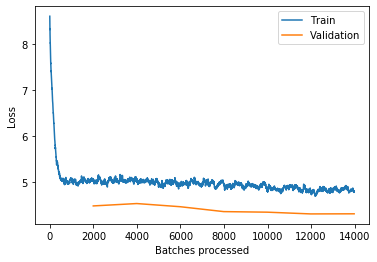

In [20]:
fig = cls_learn.recorder.plot_losses()
experiment.log_figure(figure_name="train loss 01", figure=fig)

In [19]:
cls_learn.save('beer.clas.LIATLI.1.learner')

In [60]:
cls_learn.load('beer.clas.attfullind400.1.learner')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (63909 items)
x: TextList
xxbos a lot of foam xxperiod xxmaj but a lot xxperiod xxmaj in the smell some banana , and then lactic and tart xxperiod xxmaj not a good start xxperiod xxmaj quite dark orange in color , with a lively carbonation ( now visible , under the foam ) xxperiod xxmaj again tending to lactic sourness xxperiod xxmaj same for the taste xxperiod xxmaj with some yeast and banana xxperiod,xxbos xxmaj almost totally black xxperiod xxmaj beige foam , quite compact , not bad xxperiod xxmaj light smell , just a bit of roast , and some hop xxperiod a bit too light xxperiod xxmaj the taste is light oo , and drinkable , with some malt , roast , hints of coffee xxperiod xxmaj nothing exceptional , but after all drinkable and pleasant xxperiod xxmaj light to average body xxperiod xxmaj in the aftertaste some dust , xxunk roast , hint of caramel , and a bit of bitterness xxperiod xxmaj no defect , drinkable , not bad xxperiod,xxb

In [21]:
cls_learn.unfreeze()

UN-FREEZING
Sequential(
  (0): Embedding(31600, 400, padding_idx=1)
  (1): EmbeddingDropout(
    (emb): Embedding(31600, 400, padding_idx=1)
  )
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(400, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 1152, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): WeightDropout(
    (module): LSTM(1152, 400, batch_first=True)
  )
  (1): RNNDropout()
)
UN-FREEZING
Sequential(
  (0): Cls02_LIATLI(
    (aspect): Sequential(
      (0): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Linear(in_features=800, out_features=40, bias=True)
      (3): LeakyReLU(negative_slope=0.01, inplace=True)
      (4): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.15, inplace=False)
      (6): Linear(in_features=40, ou

In [23]:
# FULL INDIPENDENT
with experiment.train():
    cls_learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,multi_acc,clas_acc_0,clas_acc_1,clas_acc_2,clas_acc_3,clas_acc_4,clas_mse_0,clas_mse_1,clas_mse_2,clas_mse_3,clas_mse_4,time
0,4.788064,4.298103,0.611442,0.606748,0.593717,0.646912,0.607462,0.602374,0.496073,0.464655,0.434488,0.462335,0.479025,05:06
1,4.600244,4.137919,0.621992,0.615494,0.604963,0.654588,0.617637,0.617280,0.482953,0.447965,0.422974,0.451089,0.456176,05:02
2,4.412610,4.076941,0.629579,0.622813,0.608890,0.664227,0.624420,0.627544,0.467333,0.443770,0.404141,0.446091,0.449036,05:03
3,4.388107,4.029789,0.634505,0.631560,0.611567,0.672617,0.628526,0.628258,0.459122,0.443502,0.391289,0.435916,0.436987,05:04
4,4.260339,3.979668,0.639164,0.635577,0.615584,0.673956,0.634863,0.635844,0.450107,0.447251,0.391289,0.428418,0.432613,05:04
5,4.214543,3.988944,0.636612,0.631471,0.611478,0.670475,0.637362,0.632274,0.449661,0.452160,0.399589,0.423956,0.439932,04:54
6,4.218116,3.977113,0.638718,0.636112,0.611924,0.675830,0.637005,0.632720,0.448590,0.446358,0.388076,0.423956,0.437165,04:59
7,4.203924,3.941751,0.643127,0.639057,0.618261,0.679668,0.638433,0.640218,0.438683,0.434398,0.383702,0.422081,0.424581,05:16
8,4.125604,3.950826,0.640236,0.637362,0.616030,0.674402,0.638343,0.635041,0.444484,0.440111,0.390218,0.419225,0.432167,04:57
9,4.087418,3.939092,0.643163,0.638700,0.619065,0.677437,0.639950,0.640664,0.442610,0.433595,0.384595,0.416012,0.419582,05:08


In [22]:
# LIATLI
with experiment.train():
    cls_learn.fit_one_cycle(12)

epoch,train_loss,valid_loss,multi_acc,clas_acc_0,clas_acc_1,clas_acc_2,clas_acc_3,clas_acc_4,clas_mse_0,clas_mse_1,clas_mse_2,clas_mse_3,clas_mse_4,time
0,4.764177,4.253979,0.609264,0.599875,0.597554,0.645573,0.607551,0.595769,0.537665,0.464477,0.443056,0.479829,0.479204,04:56
1,4.710799,4.201262,0.614245,0.600500,0.598983,0.647983,0.612995,0.610764,0.524456,0.467601,0.441092,0.467869,0.456176,05:18
2,4.511265,4.220484,0.613692,0.597554,0.597911,0.647537,0.608533,0.616923,0.520350,0.481703,0.429936,0.469654,0.447429,04:55
3,4.468018,4.122464,0.624474,0.614245,0.606391,0.661371,0.623081,0.617280,0.483399,0.448233,0.405837,0.439218,0.440914,05:01
4,4.483001,4.084507,0.627365,0.614066,0.612103,0.662442,0.626651,0.621564,0.483131,0.449482,0.404588,0.433952,0.437612,05:07
5,4.336730,4.047126,0.633345,0.621921,0.612995,0.668422,0.632185,0.631203,0.475723,0.436719,0.389325,0.424313,0.425652,05:09
6,4.249311,4.057905,0.636487,0.629329,0.609336,0.671724,0.636380,0.635666,0.453767,0.447340,0.382006,0.420921,0.417708,05:07
7,4.244049,3.995905,0.642288,0.637362,0.617547,0.678954,0.638433,0.639147,0.440200,0.433060,0.375848,0.417886,0.418779,04:51
8,4.161983,3.981884,0.643163,0.638343,0.616208,0.681899,0.640396,0.638968,0.439486,0.435469,0.368618,0.415030,0.420029,05:11
9,4.127716,3.992565,0.643841,0.639950,0.618083,0.681007,0.639772,0.640396,0.438593,0.446448,0.372456,0.419672,0.415655,04:55


{'web': 'https://www.comet.ml/api/image/download?imageId=0b3961087b6d4026a5778bac67999051&experimentKey=2b4c175e75bb4f35bcb54b814195ab54',
 'api': 'https://www.comet.ml/api/rest/v1/image/get-image?imageId=0b3961087b6d4026a5778bac67999051&experimentKey=2b4c175e75bb4f35bcb54b814195ab54',
 'imageId': '0b3961087b6d4026a5778bac67999051'}

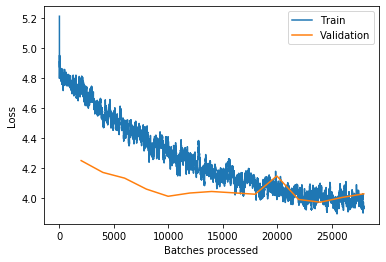

In [22]:
fig = cls_learn.recorder.plot_losses()
experiment.log_figure(figure_name="train loss 02", figure=fig)

In [40]:
cls_learn.save('beer.clas.LIATLI.2.learner')

In [20]:
cls_learn.load('beer.clas.attfullind400.2.learner')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (63909 items)
x: TextList
xxbos a lot of foam xxperiod xxmaj but a lot xxperiod xxmaj in the smell some banana , and then lactic and tart xxperiod xxmaj not a good start xxperiod xxmaj quite dark orange in color , with a lively carbonation ( now visible , under the foam ) xxperiod xxmaj again tending to lactic sourness xxperiod xxmaj same for the taste xxperiod xxmaj with some yeast and banana xxperiod,xxbos xxmaj almost totally black xxperiod xxmaj beige foam , quite compact , not bad xxperiod xxmaj light smell , just a bit of roast , and some hop xxperiod a bit too light xxperiod xxmaj the taste is light oo , and drinkable , with some malt , roast , hints of coffee xxperiod xxmaj nothing exceptional , but after all drinkable and pleasant xxperiod xxmaj light to average body xxperiod xxmaj in the aftertaste some dust , xxunk roast , hint of caramel , and a bit of bitterness xxperiod xxmaj no defect , drinkable , not bad xxperiod,xxb

# FINISH EXPR

In [1]:
experiment.end()

NameError: name 'experiment' is not defined

# Load Test Data

In [27]:
sent_num_file = ["train.count", "test.count"]
rating_file = ["train.rating", "test.rating"]
content_file = ["train.txt", "test.txt"]

dataset_dir = "./data/beer_100k/"

In [28]:
def concat_to_doc(sent_list, sent_count):
    start_index = 0
    docs = []
    for s in sent_count:
#         doc = " xxPERIOD ".join(sent_list[start_index:start_index + s])
#         doc = doc + " xxPERIOD "
        docs.append(sent_list[start_index:start_index + s])
        start_index = start_index + s
    return docs

In [29]:
# TRAIN_DATA = 0
TEST_DATA = 1

In [30]:
# # Load Count
sent_count_test = list(open(dataset_dir + sent_num_file[TEST_DATA], "r").readlines())
sent_count_test = [int(s) for s in sent_count_test if (len(s) > 0 and s != "\n")]
print( sent_count_test[0:5] )

# Load Ratings
aspect_rating_test = list(open(dataset_dir + rating_file[TEST_DATA], "r").readlines())
aspect_rating_test = [s for s in aspect_rating_test if (len(s) > 0 and s != "\n")]

aspect_rating_test = [s.split(" ") for s in aspect_rating_test]
aspect_rating_test = np.array(aspect_rating_test)[:, :]
aspect_rating_test = aspect_rating_test.astype(np.float) - 1
aspect_rating_test = np.rint(aspect_rating_test).astype(int)  # ROUND TO INTEGER =================
aspect_rating_test = pd.DataFrame(aspect_rating_test)
print( aspect_rating_test.head() )

# Load Sents
sents_test = list(open(dataset_dir + content_file[TEST_DATA], "r").readlines())
sents_test = [s.strip() for s in sents_test]
sents_test = [s[:-1] for s in sents_test if s.endswith(".")]
print( sents_test[0:5] )

# Sents to Doc
docs_test = concat_to_doc(sents_test, sent_count_test)
docs_test = pd.DataFrame({doc:docs_test})

[13, 12, 7, 9, 6]
   0  1  2  3  4
0  3  3  4  3  4
1  2  2  2  2  2
2  3  3  3  2  3
3  3  2  2  2  4
4  2  2  2  2  2
['According to the website, the style for the Caldera Cauldron changes every year', "The current release is a DIPA, which frankly is the only cauldron I'm familiar with (it was an IPA/DIPA the last time I ordered a cauldron at the horsebrass several years back)", 'In any event', 'at the Horse Brass yesterday', 'The beer pours an orange copper color with good head retention and lacing']


In [31]:
df_test = pd.concat( [aspect_rating_test, docs_test], axis=1, ignore_index=True )
df_test.head()

,0,1,2,3,4,5
0,3,3,4,3,4,"[According to the website, the style for the C..."
1,2,2,2,2,2,"[Poured from the bottle into a Chimay goblet, ..."
2,3,3,3,2,3,"[Notes from 6/24, A: Bright golden glowing bee..."
3,3,2,2,2,4,"[22 oz, bomber,, A: Pours a clear yellow with ..."
4,2,2,2,2,2,"[Brown in color, somewhere between a porter an..."


# Test output

In [32]:
def get_clas_acc(asp_index):
    def asp_acc(preds, targs):
        preds = torch.max(preds, dim=2)[1]
        targs = targs.contiguous().long()
        return (preds[:,asp_index]==targs[:,asp_index]).float().mean()
    return asp_acc
def get_clas_mse(asp_index):
    def asp_mse(preds, targs):
        preds = torch.max(preds, dim=2)[1].float()[:,asp_index]
        targs = targs.contiguous().float()[:,asp_index]
        return torch.nn.functional.mse_loss(preds, targs)
    return asp_mse

In [33]:
def get_preds(self,
              ds_type:DatasetType,
              activ:nn.Module=None,
              with_loss:bool=False,
              n_batch:Optional[int]=None,
              pbar:Optional[PBar]=None,
              ordered:bool=False) -> List[Tensor]:
    "Return predictions and targets on the valid, train, or test set, depending on `ds_type`."
    self.model.reset()
    if ordered: np.random.seed(42)
    
    with torch.no_grad():
        outs = []
        asps = []
        for xb,yb in progress_bar(cls_learn.dl(ds_type)):
            out,raw_enc,enc,asp = cls_learn.model(xb)
            outs.append(out)
            for doc in asp:
                asps.append( to_float(doc.cpu()))

    outs = to_float(torch.cat(outs).cpu())
    
    if ordered and hasattr(self.dl(ds_type), 'sampler'):
        np.random.seed(42)
        sampler = [i for i in self.dl(ds_type).sampler]
        reverse_sampler = np.argsort(sampler)
        
        outs = outs[reverse_sampler]
        asps = [asps[i] for i in reverse_sampler]
    return (outs,asps)

In [34]:
outs,asps = get_preds(self=cls_learn, ds_type=DatasetType.Test, ordered=True)

In [35]:
outs.shape

torch.Size([24884, 6, 5])

In [36]:
target = torch.tensor( aspect_rating_test.values )
target

tensor([[3, 3, 4, 3, 4],
        [2, 2, 2, 2, 2],
        [3, 3, 3, 2, 3],
        ...,
        [4, 2, 4, 3, 4],
        [2, 2, 1, 0, 3],
        [3, 2, 4, 2, 4]])

In [37]:
mloss = MultiLabelCEL()
mloss.forward(outs, target)

tensor(3.9440)

In [38]:
pd.DataFrame.from_dict( {"ASP"+str(ai):[get_clas_acc(ai)(outs, target).item()] for ai in range(5)} )

,ASP0,ASP1,ASP2,ASP3,ASP4
0,0.634785,0.62072,0.677544,0.636152,0.634785


In [39]:
pd.DataFrame.from_dict( {"ASP"+str(ai):[get_clas_mse(ai)(outs, target).item()] for ai in range(5)} )

,ASP0,ASP1,ASP2,ASP3,ASP4
0,0.443739,0.446873,0.376909,0.420712,0.432366


# Visualize classification output

In [71]:
asp_inc_overall = True
if not asp_inc_overall: 
    nasp_analysis = hyper_params["num_aspect"] - 1
else:
    nasp_analysis = hyper_params["num_aspect"]
    
np.set_printoptions(precision=3)
asp_name = ["Overall", "Appearance", "Taste", "Palate", "Aroma"]
for i in range(10):
    print("truth:")
    print(df_test.iloc[i,0:5].values.flatten().tolist() )
    print("prediction:")
    print( torch.argmax(outs[i][0:5],dim=1) )
    print("doc:")
    dasp = torch.argmax(asps[i][:,0:nasp_analysis],dim=1).numpy()
    if asp_inc_overall: dasp_noall = torch.argmax(asps[i][:,1:6],dim=1).numpy()
#     dasp_dist = torch.nn.functional.softmax(asps[i][:,0:nasp_analysis], dim=1).numpy()
    dasp_dist = asps[i][:,0:nasp_analysis].numpy()
    for senti,s in enumerate(df_test.iloc[i,-1]):
        print(s)
        if asp_inc_overall:
            print("          +++ "+ asp_name[dasp[senti]] + " +++ " + str(dasp_dist[senti]) )
        else:
            print("          +++ "+ asp_name[dasp[senti]+1] + " +++ " + str(dasp_dist[senti]) )
    print("===========")

truth:
[3, 3, 4, 3, 4]
prediction:
tensor([3, 3, 3, 3, 4])
doc:
According to the website, the style for the Caldera Cauldron changes every year
          +++ Appearance +++ [0.02  0.042 0.021 0.014 0.032]
The current release is a DIPA, which frankly is the only cauldron I'm familiar with (it was an IPA/DIPA the last time I ordered a cauldron at the horsebrass several years back)
          +++ Appearance +++ [0.024 0.069 0.023 0.02  0.04 ]
In any event
          +++ Appearance +++ [0.025 0.072 0.026 0.021 0.04 ]
at the Horse Brass yesterday
          +++ Appearance +++ [0.025 0.079 0.027 0.022 0.04 ]
The beer pours an orange copper color with good head retention and lacing
          +++ Appearance +++ [9.225e-04 9.957e-01 5.844e-05 4.453e-03 2.528e-04]
The nose is all hoppy IPA goodness, showcasing a huge aroma of dry citrus, pine and sandlewood
          +++ Aroma +++ [7.361e-03 2.309e-02 2.116e-03 7.726e-04 9.884e-01]
The flavor profile replicates the nose pretty closely in this West 

# eval

In [72]:
def eval_hotel_asp(asp_pred, asp_true, asp_inc_overall):
    asp_to_id = {"appearance":0, "taste":1, "palate":2, "aroma":3, "none":-1}
    asp_true = np.array( [asp_to_id[l] for l in asp_true] )
    print("total true: " + str(len(asp_true)) )
    print("total not none: " + str(sum(asp_true>0)) )
    
    asp_pred_index = []
    if asp_inc_overall:
        for i in range(1000):
            asp_pred_index.append( asp_pred[i][:,1:6].numpy().argsort() )
    else:
        for i in range(1000):
            asp_pred_index.append( asp_pred[i][:,0:5].numpy().argsort() )
    asp_pred_index = np.concatenate( asp_pred_index , axis=0)
    
    result_index = []
    for i,lbl in enumerate(asp_true):
        if(lbl==-1):
            result_index.append(-1)
        else:
            at = np.where(asp_pred_index[i,] == lbl)
            result_index.append(at[0][0])
    result_index = np.array(result_index)
    
    print("Top 1 ACC:")
    print( sum(result_index>=4) / sum(result_index>=0) )
    print("Top 2 ACC:")
    print( sum(result_index>=3) / sum(result_index>=0) )

In [1]:
dataset_dir

NameError: name 'dataset_dir' is not defined

In [49]:
yifan_label = open(dataset_dir + "test_aspect_0.yifanmarjan.aspect", "r").readlines()
yifan_label = [s.split()[0] for s in yifan_label]

In [50]:
eval_hotel_asp(asps, yifan_label, asp_inc_overall=True)

total true: 1000
total not none: 454
Top 1 ACC:
0.6763005780346821
Top 2 ACC:
0.9152215799614644


In [51]:
fan_label = open(dataset_dir + "test_aspect_0.fan.aspect", "r").readlines()
fan_label = [s.split()[0] for s in fan_label]

In [52]:
eval_hotel_asp(asps, fan_label, asp_inc_overall=True)

total true: 621
total not none: 288
Top 1 ACC:
0.6814159292035398
Top 2 ACC:
0.887905604719764
